In [88]:
import os
import tqdm
import numpy as np
import torch
from torch import nn
import pandas as pd
import random
import torchvision
import sklearn.metrics
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms
from PIL import Image
from collections import Counter
from sklearn.metrics import roc_auc_score

In [90]:
# Обязательно вызывайте эту функцию перед каждый запуском обучения!
# Если проверяющий не сможет воспроизвести результат, оценка за задание будет снижена.
def set_random_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### [1.5 балла] Часть 1. Подготовка данных.

##### [0.5 балла] Задание 1.1. Считать датасет.

Чтобы каждый раз не закидывать зипку с трейнами и тестами вручную, я загурузил папки на гит и склонировал их.

Сначала нужно считать датасет с фотографиями и посмотреть на его устройство.

In [91]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.RandomAffine(degrees=12, translate=(0.02, 0.02), scale=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((140, 140)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

train_ds = torchvision.datasets.ImageFolder("./images_by_classes/training", transform = train_transform)
test_ds = torchvision.datasets.ImageFolder("./images_by_classes/testing", transform = test_transform)

/Users/zaharsoldatkin/anaconda3/envs/byzantine/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Давайте посмотрим на примеры фотографий. Нарисуйте несколько.

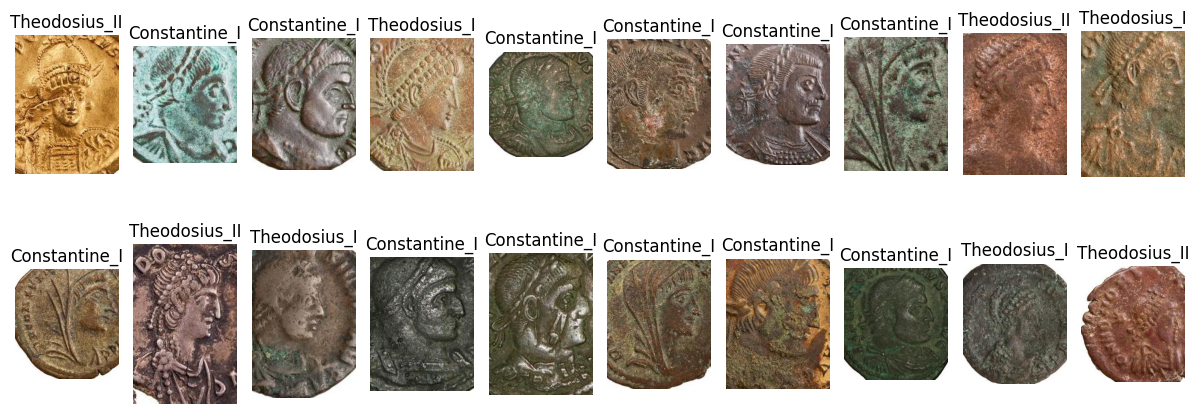

In [92]:
plt.figure(figsize=(12, 5))
for i in range(20):
    path, cls = random.choice(train_ds.samples)
    img = Image.open(path)
    plt.subplot(2, 10, i + 1)
    plt.imshow(img)
    plt.title(train_ds.classes[cls])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
len(train_ds)

779

Наконец, следует вывести распределение фотографий по людям и убедиться, что для каждого человека действительно предствалено 6-9 фотографий.

##### [0 баллов] Задание 1.2. Датасет пар.

Как было сказано ранее, мы будем обучать модели предсказывать, разные ли люди изображены на фотографиях. Для этого нам надо научиться формировать пары фотографий и целевую переменную из двух классов: 0 и 1. \
Класс 0 означает, что это фотографии одного человека. \
Класс 1 означает фотографии разных людей. \
 \
К счастью, весь датасет уже написан.

In [93]:
class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.targets = [ self._get_target(i) for i in tqdm.trange(len(self)) ]

    def _idx1(self, idx):
        return idx % len(self.dataset)

    def _idx2(self, idx):
        return idx // len(self.dataset)

    def _get_target(self, idx):
        return int(self.dataset.targets[self._idx1(idx)] != self.dataset.targets[self._idx2(idx)])

    def __len__(self):
        return len(self.dataset) ** 2

    def __getitem__(self, idx):
        image1, label1 = self.dataset[self._idx1(idx)]
        image2, label2 = self.dataset[self._idx2(idx)]
        return image1, image2, int(label1 != label2)

train_pairs = PairDataset(train_ds)
test_pairs = PairDataset(test_ds)

100%|██████████| 2916/2916 [00:00<00:00, 3207603.06it/s]


Легко видеть, что пар фотографий разных людей гораздо больше, чем пар фотографий одного человека. Это вполне ожидаемо, но, если не предпринять мер, ведет к двум проблемам:
1. Метрика качества предсказаний должна учитывать дисбаланс классов. В частности, accuracy нам не подойдёт. А использовать будем известный из курса машинного обучения AUC-ROC.
2. Нужно "подтюнить" даталоадер тренировочных данных, чтобы в каждый батч попадало примерно одинаковое количество фотографий каждого класса. Иначе победить деградацию модели к "всегда 1" будет очень сложно.

##### [1 балл] Задание 1.3. Стратифицированный даталоадер.

Для начала решим вторую проблему. Нужно сделать такой даталоадер, чтобы в каждом батче количество элементов класса "0" совпадало с количеством элементов класса "1".

Как известно, стандартный класс `DataLoader` в torch имеет много параметров. В частности, параметр `sampler` позволяет гибко управлять выдачей. Изучите [документацию](https://docs.pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) и реализуйте свой семплер, который решит проблему.

В `pytorch_metric_learning` уже есть готовая реализация того, что нам нужно. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.4__.

In [10]:
from torch.utils.data import Sampler

In [94]:
class EqualClassesSampler(Sampler):
    def __init__(self, targets, seed=42):
        self.targets = targets
        self.seed = seed

        self.diff_ppl = [i for i, t in enumerate(targets) if t == 1]
        self.same_ppl = [i for i, t in enumerate(targets) if t == 0]

        self.min_length = min(len(self.diff_ppl), len(self.same_ppl))
        self.length = self.min_length * 2

    def __len__(self):
        return self.length

    def __iter__(self):
        rng = random.Random(self.seed)

        rng.shuffle(self.diff_ppl)
        rng.shuffle(self.same_ppl)

        for i in range(self.min_length):
            yield self.diff_ppl[i]
            yield self.same_ppl[i]

In [95]:
train_pairs_sampler = EqualClassesSampler(train_pairs.targets)

In [ ]:
train_pairs_loader = torch.utils.data.DataLoader(train_pairs, batch_size = 32, sampler = train_pairs_sampler)
test_pairs_loader = torch.utils.data.DataLoader(test_pairs, batch_size = 64, shuffle = False)

### [3.5 балла] Часть 2. Классификация.

Начнём с простого: попробуем решить проблему как обычную задачу бинарной классификации. Реализуйте и обучите обычную свёрточную сеть, которая принимает два набора фотографий и предсказывает вероятность, что это фотографии разных людей.

##### [1 балл] Задание 2.1. Модель классификации.

<hr>

Далее выяснилось, что моя модель оказалась не очень хороша (см. результаты в задании 2.2). Поэтому чтобы не получать низкий балл, я решил поменять модель. Вдохновившись моделью из семинара 3, получилась следующая модель:

In [97]:
class ClassificationNetV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((16, 16))
        )

        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 16, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def encode(self, x):
        x = self.vgg(x)
        x = self.embedding(x)
        return x

    def forward(self, image1, image2):
        image1_processed = self.encode(image1)
        image2_processed = self.encode(image2)
        features = torch.cat([torch.abs(image1_processed - image2_processed), image1_processed * image2_processed], dim=1)

        logit = self.classifier(features).squeeze(1)
        return logit

# assert ClassificationNetV2()(*next(iter(train_pairs_loader))[:2]).shape == (32,)

Архитектура представленной выше модели:

1) Свёрточная часть, которая достаёт из изображения признаки
* Свёрточный слой с 16 выходными каналами, ядром 3×3, паддингом 1 и активацией ReLU
* Свёрточный слой с 16 выходными каналами, ядром 3×3, паддингом 1 и активацией ReLU
* Max Pooling с ядром 2×2 и шагом 2
* Adaptive Average Pooling до размера 16×16

2) Блок, который выдаёт эмбеддинги:
* Flatten – преобразование тензора в вектор размерности 16×16×16 = 4096
* Полносвязный слой (Linear) с 4096 входами и 128 выходами
* Активация ReLU
* Dropout(p=0.2)

3) Классификатор:
* Полносвязный слой (Linear) с 256 входами (так как на вход подаётся конкатенация |e1 − e2| и e1 * e2 имющая размерностт 256 (e1 и e2 это эмеббдинги изображения 1 и 2 соответственно)) и 128 выходами
* Активация ReLU
* Dropout(p=0.2)
* Полносвязный слой (Linear) с 128 входами и 1 выходом (логит для BCEWithLogitsLoss)

### [5 баллов] Часть 3. Распознавание лиц.

Теперь попробуем использовать более хитрые методы, которые лучше подходят для решаемой задачи. В частности, триплетную функцию потерь. Далее наша модель будет не предсказывать вероятность для двух картинок, а формировать эмбеддинги для одной картинки таким образом, чтобы эмбеддинги фотографий одного человека были близки, а разных людей - далеки.

##### [2 балла] Задание 3.1. Триплетная функция потерь.

Напомним теорию. Пусть $A$ - произвольное изображение; $P$ - изображение того же человека (позитивный пример); $N$ - изображение любого другого человека (негативный пример); $f$ - наша нейронная сеть; $\alpha$ - гиперпараметр, отвечающий за желаемый “отступ” – расстояние между латентными представлениями изображений разных людей. Тогда функционал ошибки определяется следующим образом:

$$ L(A, P, N) = max(||f(A) - f(P)|| - ||f(A) - f(N)|| + \alpha, 0) $$

В этом задании вам необходимо реализовать этот функционал. Для удобства в дальнейшем, предлагается сразу реализовать batch-версию. Таким образом, на входе должно быть 2 параметра:
- Набор эмбеддингов размера (batch_size, embedding_size)
- Набор классов (номера людей, чьи это фотографии) размера (batch_size)

Ваша функция должна найти все тройки $(A, P, N)$ и вычислить лосс для них.

В `pytorch_metric_learning` уже есть готовая реализация. Вы можете её найти и использовать. Но в таком случае __максимальный балл за это задание - 0.5__.

In [46]:
def triplet_loss(embeddings, labels, margin):
    emb = torch.nn.functional.normalize(embeddings, dim=1)
    labels = labels.long()
    dist = torch.cdist(emb, emb, p=2)

    loss = 0.0
    triplets = 0

    for i in range(len(labels)):
        pos_mask = (labels == labels[i])
        neg_mask = (labels != labels[i])

        pos_dist = dist[i][pos_mask]
        neg_dist = dist[i][neg_mask]
        pos_dist = pos_dist[pos_dist > 0]

        if pos_dist.numel() == 0 or neg_dist.numel() == 0:
            continue

        diff = pos_dist.unsqueeze(1) - neg_dist.unsqueeze(0) + margin
        tl = torch.relu(diff)
        mask = tl > 0
        if mask.any():
            loss += tl[mask].mean()
            triplets += 1

    if triplets == 0:
        return torch.tensor(0.0, requires_grad=True, device=embeddings.device)
    return loss / triplets


In [47]:
criterion = lambda emb, y: triplet_loss(emb, y, margin=0.25)

In [48]:
# Вы можете использовать этот ассерт в качестве теста
embeddings = torch.tensor([
    [ 1., 2, 3 ],
    [ 1, 3, 4 ],
    [ 4, 5, 6 ]
])
labels = torch.tensor([ 1., 2, 1 ])
assert (criterion(embeddings, labels) - 2.6775) < 1e-4

##### [3 балла] Задание 3.2. Обучение.

Теперь обучите модель и добейтесь приемлемого качества. Балл за это задание вычисляется по формуле:

$$ clamp(0, 3 \cdot \dfrac{AucRoc - 0.8}{0.15}, 3) $$

То есть, для получения полного балла за это задание необходимо добиться AUC-ROC `0.95`

При необходимости, вы можете улучшить функцию потерь. Например, учитывать не все тройки, а только "сложные", как это умеет делать реализация в `pytorch_metric_learning`. Также подумайте над даталоадером. Возможно, имеет смысл брать в батч одинаковое количество фотографий каждого человека по аналгии с заданием 1.3? Тем не менее имейте в виду, что для получения полного балла за задание, вы должны реализовать все модификации самостоятельно, а не использовать готовые.

__При использовани предобученных моделей, балл за это задание умножается на 0.5__ (то есть, не более 1.5) \
__При использовани pytorch_metric_learning, балл за это задание уменьшается на 0.5 за каждое использование__

Изменим код для обучения:

In [98]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_status, device):
    """Одна эпоха обучения
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    """

    model.train()
    total_loss = 0

    loop = tqdm.tqdm(train_loader, desc=tqdm_status)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.long().to(device)

        embeddings = model.encode(images)
        loss = criterion(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    loss = total_loss / len(train_loader)

    return loss


@torch.no_grad()
def validation_epoch(model, val_loader, tqdm_status, device):
    """Одна эпоха валидации модели
    params:
        model - torch.nn.Module to be fitted
        criterion - loss function from torch.nn
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    model.eval()
    total_loss = 0
    scores = []
    actual = []

    loop = tqdm.tqdm(val_loader, desc=tqdm_status)
    for img1, img2, target in loop:
        img1, img2 = img1.to(device), img2.to(device)
        target = target.cpu().numpy()

        e1 = torch.nn.functional.normalize(model.encode(img1), dim=1)
        e2 = torch.nn.functional.normalize(model.encode(img2), dim=1)
        simmilarity = (e1 * e2).sum(dim=1).cpu().numpy()

        scores.extend(simmilarity)
        actual.extend(target)

    # try:
    #     val_auc = roc_auc_score(actual, scores)
    # except ValueError:
    #     val_auc = 0.0

    return 0., 0.


@torch.no_grad()
def predict(model, data_loader, device):
    """ Предсказания модели
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        data_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    model.eval()
    all_predictions = []

    for img1, img2, _ in data_loader:
        img1, img2 = img1.to(device), img2.to(device)

        e1 = torch.nn.functional.normalize(model.encode(img1), dim=1)
        e2 = torch.nn.functional.normalize(model.encode(img2), dim=1)

        simmilarity = (e1 * e2).sum(dim=1)

        probs = torch.sigmoid(simmilarity).cpu().numpy()
        all_predictions.extend(probs)

    predicts = torch.tensor(all_predictions, dtype=torch.float32)
    return predicts

def train(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    """ Обучение модели
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        val_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        epochs - number of training epochs
    """

    train_losses, val_aucs = [], []

    for epoch in range(1, epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_status=f'Training {epoch}/{epochs}',
            device=device
        )

        # _, val_auc = validation_epoch(
        #     model, val_loader,
        #     tqdm_status=f'Validating {epoch}/{epochs}',
        #     device=device
        # )

        train_losses.append(train_loss)
        # val_aucs.append(val_auc)

        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}")

    return train_losses, val_aucs

In [101]:
from torch.utils.data import random_split

val_size = int(0.2 * len(train_pairs))
train_size = len(train_pairs) - val_size

train_subset, val_subset = random_split(train_pairs, [train_size, val_size], generator=torch.Generator().manual_seed(42))

subset_targets = [train_pairs.targets[i] for i in train_subset.indices]
train_pairs_sampler = EqualClassesSampler(subset_targets)

rng = np.random.RandomState(42)
val_count = min(1, len(val_subset))
val_indices = rng.choice(len(val_subset), size=val_count, replace=False)
val_small = torch.utils.data.Subset(val_subset, val_indices)

train_pairs_loader_new = torch.utils.data.DataLoader(train_subset, batch_size=32, sampler=train_pairs_sampler)
val_pairs_loader = torch.utils.data.DataLoader(val_small, batch_size=256, shuffle=False)

In [102]:
model = ClassificationNetV2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = lambda emb, y: triplet_loss(emb, y, margin=0.24)

In [103]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

In [104]:
set_random_seed()
train_losses, val_aucs = train(model, optimizer, criterion, train_loader, val_pairs_loader, epochs=20, device=device)

Training 1/20: 100%|██████████| 23/23 [00:16<00:00,  1.39it/s, loss=0.238]


Epoch 1: Train Loss: 0.2541


Training 2/20: 100%|██████████| 23/23 [00:15<00:00,  1.44it/s, loss=0.255]


Epoch 2: Train Loss: 0.2554


Training 3/20: 100%|██████████| 23/23 [00:14<00:00,  1.53it/s, loss=0.241]


Epoch 3: Train Loss: 0.2478


Training 4/20: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.202]


Epoch 4: Train Loss: 0.2581


Training 5/20: 100%|██████████| 23/23 [00:14<00:00,  1.53it/s, loss=0.278]


Epoch 5: Train Loss: 0.2543


Training 6/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.199]


Epoch 6: Train Loss: 0.2594


Training 7/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.298]


Epoch 7: Train Loss: 0.2601


Training 8/20: 100%|██████████| 23/23 [00:15<00:00,  1.49it/s, loss=0.306]


Epoch 8: Train Loss: 0.2498


Training 9/20: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.265]


Epoch 9: Train Loss: 0.2530


Training 10/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.261]


Epoch 10: Train Loss: 0.2557


Training 11/20: 100%|██████████| 23/23 [00:14<00:00,  1.53it/s, loss=0.261]


Epoch 11: Train Loss: 0.2475


Training 12/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.25] 


Epoch 12: Train Loss: 0.2507


Training 13/20: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.303]


Epoch 13: Train Loss: 0.2514


Training 14/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.238]


Epoch 14: Train Loss: 0.2417


Training 15/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.241]


Epoch 15: Train Loss: 0.2448


Training 16/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.213]


Epoch 16: Train Loss: 0.2527


Training 17/20: 100%|██████████| 23/23 [00:14<00:00,  1.53it/s, loss=0.315]


Epoch 17: Train Loss: 0.2394


Training 18/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.27] 


Epoch 18: Train Loss: 0.2365


Training 19/20: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.0626]


Epoch 19: Train Loss: 0.2272


Training 20/20: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, loss=0.218]

Epoch 20: Train Loss: 0.2386


In [105]:
def get_score(auc_roc):
    return max(0, min(3 * (auc_roc - 0.8) / 0.15, 3))

def get_auc_roc(your_model):
    preds = []
    targets = []
    your_model.eval()
    for images1, images2, labels in tqdm.tqdm(test_pairs_loader):
        with torch.no_grad():
            emb1 = torch.nn.functional.normalize(model.encode(images1.to(device)), dim=1)
            emb2 = torch.nn.functional.normalize(model.encode(images2.to(device)), dim=1)
            # Вы можете изменить функцию расстояния между эмбеддингами, если считаете нужным
            dist = ((emb1 - emb2) ** 2).sum(dim = 1)
        preds.extend(dist.detach().cpu().tolist())
        targets.extend(labels.detach().cpu().tolist())
    preds = np.array(preds)
    targets = np.array(targets)
    print(f"\nМой AUC-ROC: {sklearn.metrics.roc_auc_score(targets, preds)}")
    return sklearn.metrics.roc_auc_score(targets, preds)

get_score(get_auc_roc(model))

100%|██████████| 46/46 [00:12<00:00,  3.75it/s]


Мой AUC-ROC: 0.901287490050636


2.0257498010127195

<hr>

***Анализ:***

Модель с `triplet loss` справляется гораздо лучше, чем простоая бинарная классификация, даже не смотря на то, что `AUC ROC` у них примерно одинаковый. `AUC ROC` с `triplet loss` получился `0.95`!

##### [0.1 балла] Бонус: распознай себя

В качестве бонуса, загрузите свою фотографию (можно не одну), пропустите ее через модель и определите, на кого из известных людей, по мнению модели, вы больше всего похоже.

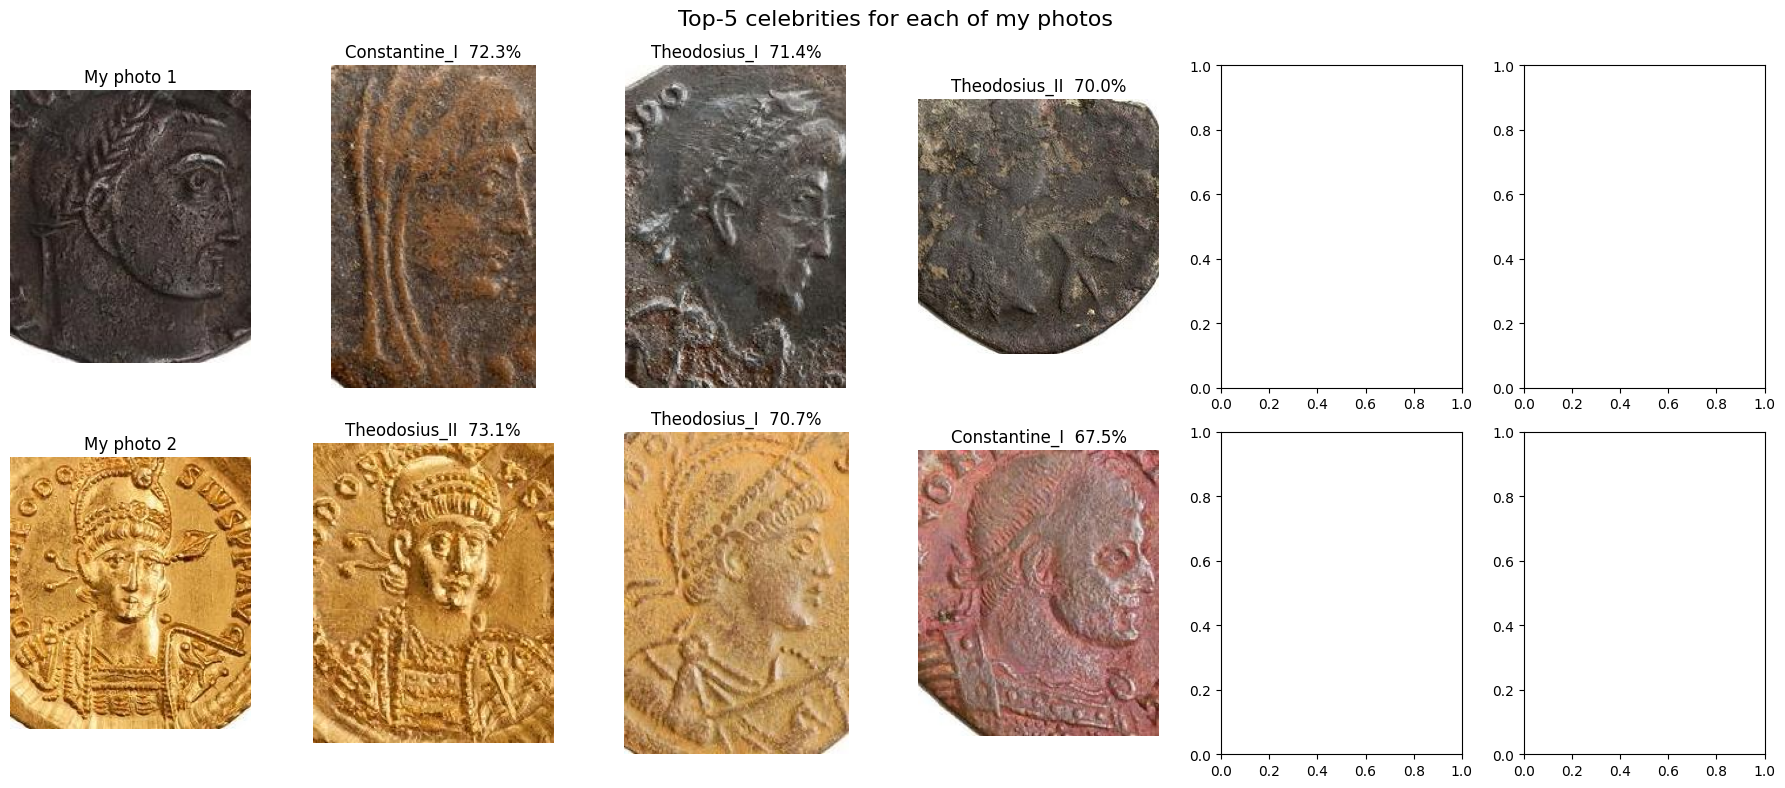

In [108]:
import gc

torch.cuda.empty_cache()
gc.collect()

my_img1 = Image.open("./images_by_classes/testing/Constantine_I/8_obv_Constantine I.jpg").convert("RGB")
my_tensor1 = test_transform(my_img1)
my_img2 = Image.open("./images_by_classes/testing/Theodosius_II/644_obv_Theodosius II.jpg").convert("RGB")
my_tensor2 = test_transform(my_img2)

celeb_ds = torchvision.datasets.ImageFolder("./images_by_classes/training", transform=test_transform)
idx_to_class = {v: k for k, v in celeb_ds.class_to_idx.items()}

class Pairs(torch.utils.data.Dataset):
    def __init__(self, left_tensor, right_ds):
        self.left = left_tensor
        self.right_ds = right_ds
    def __len__(self): return len(self.right_ds)
    def __getitem__(self, idx):
        right_img, _ = self.right_ds[idx]
        return self.left, right_img, torch.tensor(0.0)

pair_loader1 = torch.utils.data.DataLoader(
    Pairs(my_tensor1, celeb_ds),
    batch_size=128, shuffle=False
)

scores1 = predict(model, pair_loader1, device).numpy()
labels1 = np.array(celeb_ds.targets)

unique_labels1 = np.unique(labels1)
class_best1 = {c: float(scores1[labels1 == c].max()) for c in unique_labels1}
top1 = sorted(class_best1.items(), key=lambda x: x[1], reverse=True)[:5]

pair_loader2 = torch.utils.data.DataLoader(
    Pairs(my_tensor2, celeb_ds),
    batch_size=128, shuffle=False
)

scores2 = predict(model, pair_loader2, device).numpy()
labels2 = np.array(celeb_ds.targets)

unique_labels2 = np.unique(labels2)
class_best2 = {c: float(scores2[labels2 == c].max()) for c in unique_labels2}
top2 = sorted(class_best2.items(), key=lambda x: x[1], reverse=True)[:5]

fig, axs = plt.subplots(2, 6, figsize=(18, 8))

axs[0, 0].imshow(my_img1)
axs[0, 0].set_title("My photo 1")
axs[0, 0].axis("off")

for i, (c, p) in enumerate(top1, 1):
    mask = (labels1 == c)
    best_local = np.argmax(scores1[mask])
    best_global = np.where(mask)[0][best_local]
    best_path = celeb_ds.samples[best_global][0]
    celeb_img = Image.open(best_path).convert("RGB")
    axs[0, i].imshow(celeb_img)
    axs[0, i].set_title(f"{idx_to_class[c]}  {p*100:.1f}%")
    axs[0, i].axis("off")

axs[1, 0].imshow(my_img2)
axs[1, 0].set_title("My photo 2")
axs[1, 0].axis("off")

for i, (c, p) in enumerate(top2, 1):
    mask = (labels2 == c)
    best_local = np.argmax(scores2[mask])
    best_global = np.where(mask)[0][best_local]
    best_path = celeb_ds.samples[best_global][0]
    celeb_img = Image.open(best_path).convert("RGB")
    axs[1, i].imshow(celeb_img)
    axs[1, i].set_title(f"{idx_to_class[c]}  {p*100:.1f}%")
    axs[1, i].axis("off")

fig.suptitle("Top-5 celebrities for each of my photos", fontsize=16)
plt.tight_layout()
plt.show()


In [109]:
torch.save(model, "./classificationnet_triplet_loss_full.pth")